In [211]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

from yellowbrick.regressor import PredictionError
from yellowbrick.model_selection import ValidationCurve

%matplotlib inline

In [137]:
fileLoc = 'games.csv'
df = pd.read_csv(fileLoc, sep=',')

In [138]:
nRows, nCols = df.shape
df.head()

,id,type,name,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,12333,boardgame,Twilight Struggle,2005.0,2.0,2.0,180.0,180.0,180.0,13.0,20113,8.33774,8.22186,26647,372,1219,5865,5347,2562,3.4785
1,120677,boardgame,Terra Mystica,2012.0,2.0,5.0,150.0,60.0,150.0,12.0,14383,8.28798,8.14232,16519,132,1586,6277,2526,1423,3.8939
2,102794,boardgame,Caverna: The Cave Farmers,2013.0,1.0,7.0,210.0,30.0,210.0,12.0,9262,8.28994,8.06886,12230,99,1476,5600,1700,777,3.7761
3,25613,boardgame,Through the Ages: A Story of Civilization,2006.0,2.0,4.0,240.0,240.0,240.0,12.0,13294,8.20407,8.05804,14343,362,1084,5075,3378,1642,4.1590
4,3076,boardgame,Puerto Rico,2002.0,2.0,5.0,150.0,90.0,150.0,12.0,39883,8.14261,8.04524,44362,795,861,5414,9173,5213,3.2943


In [139]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81312 entries, 0 to 81311
Data columns (total 20 columns):
id                      81312 non-null int64
type                    81312 non-null object
name                    81271 non-null object
yearpublished           81309 non-null float64
minplayers              81309 non-null float64
maxplayers              81309 non-null float64
playingtime             81309 non-null float64
minplaytime             81309 non-null float64
maxplaytime             81309 non-null float64
minage                  81309 non-null float64
users_rated             81312 non-null int64
average_rating          81312 non-null float64
bayes_average_rating    81312 non-null float64
total_owners            81312 non-null int64
total_traders           81312 non-null int64
total_wanters           81312 non-null int64
total_wishers           81312 non-null int64
total_comments          81312 non-null int64
total_weights           81312 non-null int64
average_weight  

In [140]:
# Separate out my two types of columns
categoryCols = ['type','name']
numericalCols = np.setdiff1d(df.columns, categoryCols)

In [141]:
# Curious if there was another type
df['type'].unique()

array(['boardgame', 'boardgameexpansion'], dtype=object)

In [142]:
df.describe()

,id,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
count,81312.000000,81309.000000,81309.000000,81309.000000,81309.000000,81309.000000,81309.000000,81309.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000
mean,72278.150138,1806.630668,1.992018,5.637703,51.634788,49.276833,51.634788,6.983975,161.886585,4.212144,1.157632,262.502509,9.236423,12.688890,42.719144,49.290031,16.488009,0.908083
std,58818.237742,588.517834,0.931034,56.076890,345.699969,334.483934,345.699969,5.035138,1145.978126,3.056551,2.340033,1504.536693,39.757408,60.764207,239.292628,284.862853,115.980285,1.176002
min,1.000000,-3500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21339.750000,1984.000000,2.000000,2.000000,8.000000,10.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,43258.000000,2003.000000,2.000000,4.000000,30.000000,30.000000,30.000000,8.000000,2.000000,5.265620,0.000000,7.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,128836.500000,2010.000000,2.000000,6.000000,60.000000,60.000000,60.000000,12.000000,16.000000,6.718777,0.000000,51.000000,2.000000,3.000000,7.000000,9.000000,2.000000,1.916700
max,184451.000000,2018.000000,99.000000,11299.000000,60120.000000,60120.000000,60120.000000,120.000000,53680.000000,10.000000,8.221860,73188.000000,1395.000000,1586.000000,6402.000000,11798.000000,5996.000000,5.000000


Interesting, we have a negative year, max of maxplayer sounds a little ridiculous, who wants to play a game that lasts 60120. I'm pretty sure most babies don't have the capacity to play video games.

## Question 1

Assumptions: It appears the main focus is the rating of the board games based on various influencing factors. 

Information we can get from this data:

- Distribution of age of players
- Number of games released per year
- How does playing time influence rating
- Rating of the game for those that own vs those that don't
- A potential correlation between game hype vs actual enjoyment based on rating and user's trading.

Technically, we can glean some type of information from all of these columns (except id and weights unless I can determine an educated guess on what that column is being used for). It really depends on what information you are trying to determine. Do you want to develop a board game around the ideal playtime length? Do you want to develop a board game for a specific age and what type of games does this age range enjoy?

## Question 2

That's kind of a trick question. Any model could be built from this data. The worth of the model would be completely dependent on the question you are trying to answer as a company. Two potential models:

Classification:
- Predict whether a game will be popular (threshold based on average_rating)

Regression
- Predict the length of a game based on min-max players and typical age range

In [143]:
# Let's look at the count of missing data per column
df.isnull().sum(axis=0)

id                       0
type                     0
name                    41
yearpublished            3
minplayers               3
maxplayers               3
playingtime              3
minplaytime              3
maxplaytime              3
minage                   3
users_rated              0
average_rating           0
bayes_average_rating     0
total_owners             0
total_traders            0
total_wanters            0
total_wishers            0
total_comments           0
total_weights            0
average_weight           0
dtype: int64

In [144]:
# Create an array of columns with missing values
colMissValues = ['yearpublished','minplayers','maxplayers','playingtime','minplaytime','maxplaytime']

In [145]:
# I want to see if the missing values are all in the same rows
for col in colMissValues:
    print(df[col][df[col].isnull()])

45972   NaN
46057   NaN
46537   NaN
Name: yearpublished, dtype: float64
45972   NaN
46057   NaN
46537   NaN
Name: minplayers, dtype: float64
45972   NaN
46057   NaN
46537   NaN
Name: maxplayers, dtype: float64
45972   NaN
46057   NaN
46537   NaN
Name: playingtime, dtype: float64
45972   NaN
46057   NaN
46537   NaN
Name: minplaytime, dtype: float64
45972   NaN
46057   NaN
46537   NaN
Name: maxplaytime, dtype: float64


Missing information id is the same for all listed columns so we will drop them from our analysis for this particular purpose.

In [146]:
# Drop rows that have missing values but only in a subset which doesn't include name
df.dropna(subset=colMissValues, inplace=True)

In [147]:
# Verify I didn't delete more than expected
print(nRows - df.shape[0])

3


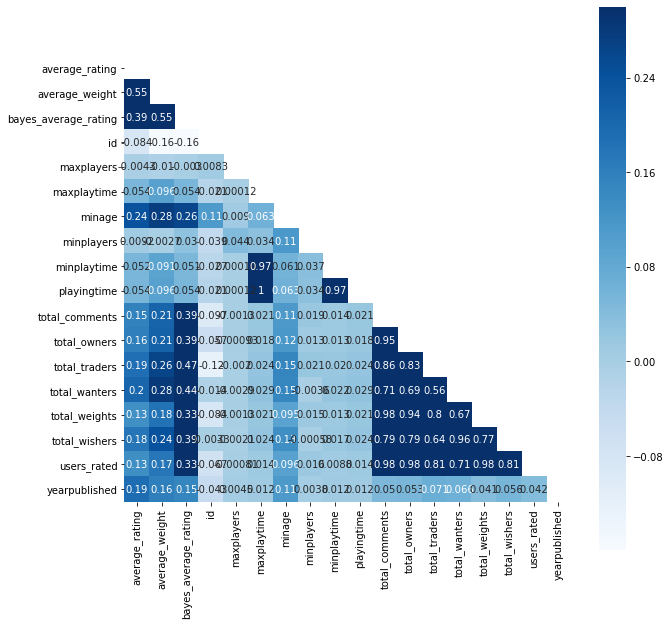

In [73]:
# Plot out a feature correlation map 
corr = df[numericalCols].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 10))
ax = sns.heatmap(corr, mask=mask, cmap="Blues", vmax=.3, square=True, annot=True)

Large correlation between owners, wanters, wishers, and users_rated which would make sense. Our data is biased towards those that are interested in these types of games and it's hard to rate a game never played. We will leave these in the dataset for now and see how it effects our models.

## Question 3
Let's build a model to predict how popular a game is likely to be based on the data available

### Let's clean up our data based on what we learned earlier

In [148]:
# Map id to boardname
idMap = {}
idMap = df['id'].map(df['name'])

(array([24379.,   606.,  1325.,  3303.,  6687., 12277., 15847., 11737.,
         3860.,  1288.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

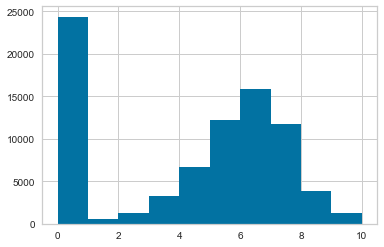

In [149]:
# Look at distribution of target variables
plt.hist(df['average_rating'])

(array([8.0809e+04, 3.4100e+02, 8.1000e+01, 3.7000e+01, 1.7000e+01,
        4.0000e+00, 8.0000e+00, 4.0000e+00, 4.0000e+00, 4.0000e+00]),
 array([    0.,  5368., 10736., 16104., 21472., 26840., 32208., 37576.,
        42944., 48312., 53680.]),
 <a list of 10 Patch objects>)

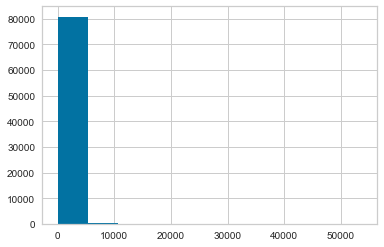

In [150]:
# Look at distribution of the number of user ratings
plt.hist(df['users_rated'])

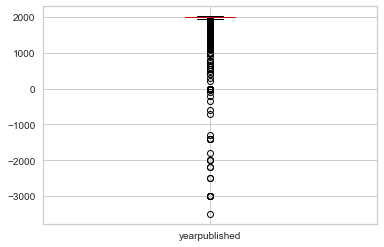

In [151]:
df.boxplot(column=['yearpublished'])

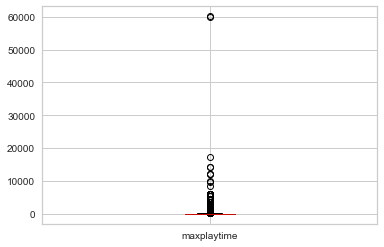

In [152]:
df.boxplot(column=['maxplaytime'])

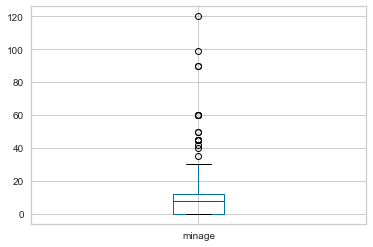

In [153]:
df.boxplot(column=['minage'])

In [207]:
# Ok, let's put some boundaries on this data

# First we need the game to be at least rated
dfClean = df[df['users_rated'] > 0]

# Let's limit to board games made within the last 75 years (1944)
dfClean = dfClean[dfClean['yearpublished']>1944]

# Let's limit the max play time to 8 hours, I'm assuming this in minutes so (480)
dfClean = dfClean[dfClean['maxplaytime']<480]

# Let's make sure the player can at least talk so let's go with a min age of 4
dfClean = dfClean[dfClean['minage'] > 4]

# Make sure we don't have empty rows
dfClean = dfClean.dropna(axis=0)

In [208]:
# One hot encode our board type
dfTemp = pd.get_dummies(dfClean['type'], prefix='type')
dfClean = pd.concat([dfClean, dfTemp], axis=1)
dfClean.drop(['type'], axis=1, inplace=True)

In [209]:
# Create our features and target
X = dfClean.drop(['name', 'average_rating', 'id', 'bayes_average_rating'], axis=1)
y = dfClean['average_rating']

In [210]:
# Split our data into train and test
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=.2, random_state=42)

#### Run them all

In [204]:
# Quick and dirty way to run multiple models with multiple hyperparams
clfHolder = {}

clfHolder['Lasso'] = Lasso
clfHolder['RFC'] = RandomForestRegressor

defaultHypers = {
            'Lasso': {
                    'alpha': np.arange(0,1,.1)
            },
            'RFC': {'n_estimators': np.arange(20,100,20),
                    'min_samples_leaf': np.arange(1,5,1),
                    'min_samples_split': np.arange(2,6,1),
                    'n_jobs': [-1],
                    }
            }

In [212]:
bestResult = None

# Convert hyperparameters into value I can pass into model
def getHyperPermutations(clfName):
    tmpHyper = defaultHypers[clfName]

    # Credit: https://stackoverflow.com/questions/5228158/cartesian-product-of-a-dictionary-of-lists
    keys = tmpHyper.keys()
    vals = tmpHyper.values()
    for instance in it.product(*vals):
        yield dict(zip(keys, instance))

bestScore = 1000

# Loop through each model and hyperparam settings
for clfName in clfHolder.keys():
    print(f"Running Classifier: {clfName}")

    clfType = clfHolder[clfName]

    hyperPermutations = list(getHyperPermutations(clfName))

    for paramIdx, permutation in enumerate(hyperPermutations):
        rmse = -1

        clf = clfType(**permutation)

        # Sanity check that this regressor will even work
        try:
            clf.fit(xTrain, yTrain)
            yHat = clf.predict(xTest)
            
            rmse = np.sqrt(mean_squared_error(yHat, yTest))

        except Exception as e:
            print(f"Classifier {clf} failed with the following error:\n{e}\nResuming Search.")

        print(f"RMSE: {rmse}")

        if rmse < bestScore:
            bestResult = clf
                
print(f"{bestResult}")

Running Classifier: Lasso


C:\Users\Brett\Anaconda64\envs\ncino\lib\site-packages\ipykernel_launcher.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
C:\Users\Brett\Anaconda64\envs\ncino\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\Brett\Anaconda64\envs\ncino\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24100.79629760227, tolerance: 6.89056058281083
  positive)


RMSE: 1.2426558328878266
RMSE: 1.278811860121163
RMSE: 1.2976332481940178
RMSE: 1.3180671297115854
RMSE: 1.3231146773782319
RMSE: 1.328163483553486
RMSE: 1.3343962624321162
RMSE: 1.3372559379138085
RMSE: 1.3379541357001306
RMSE: 1.338695615495281
Running Classifier: RFC
RMSE: 1.1151068109526592
RMSE: 1.1046071037398457
RMSE: 1.1161610423201953
RMSE: 1.1058098304506252
RMSE: 1.0956176839063558
RMSE: 1.1030108770651839
RMSE: 1.1128519686573035
RMSE: 1.1070421343877423
RMSE: 1.0997743474671808
RMSE: 1.0976592396790221
RMSE: 1.0972543191767665
RMSE: 1.09508026806996
RMSE: 1.0905415157417804
RMSE: 1.0984720711334588
RMSE: 1.091564516052873
RMSE: 1.0965182190607916
RMSE: 1.099390338895507
RMSE: 1.09397417163451
RMSE: 1.0954007708469389
RMSE: 1.0942346742844153
RMSE: 1.092833278510365
RMSE: 1.0869926482911056
RMSE: 1.0893812020375377
RMSE: 1.0919733740671826
RMSE: 1.0867444283582308
RMSE: 1.0845855957463932
RMSE: 1.0888653765176572
RMSE: 1.0871386711019713
RMSE: 1.0852329240959926
RMSE: 1.088

As expected, random forest did the best. It's my go-to for most simple models.

In [220]:
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

rf.fit(xTrain, yTrain)
yHat = rf.predict(xTest)
rmse = np.sqrt(mean_squared_error(yHat, yTest))
print(f"RMSE: {rmse}")
print(f"Feature Importance Values: {rf.feature_importances_}")

RMSE: 1.0827378882098793
Feature Importance Values: [0.214155   0.01280107 0.04626915 0.01988044 0.02729149 0.02008903
 0.04799332 0.0438014  0.07606734 0.0436259  0.04738572 0.19675359
 0.03597364 0.01300586 0.07825272 0.03385093 0.04280339]


In [221]:
X.head()

,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight,type_boardgame,type_boardgameexpansion
0,2005.0,2.0,2.0,180.0,180.0,180.0,13.0,20113,26647,372,1219,5865,5347,2562,3.4785,1,0
1,2012.0,2.0,5.0,150.0,60.0,150.0,12.0,14383,16519,132,1586,6277,2526,1423,3.8939,1,0
2,2013.0,1.0,7.0,210.0,30.0,210.0,12.0,9262,12230,99,1476,5600,1700,777,3.7761,1,0
3,2006.0,2.0,4.0,240.0,240.0,240.0,12.0,13294,14343,362,1084,5075,3378,1642,4.1590,1,0
4,2002.0,2.0,5.0,150.0,90.0,150.0,12.0,39883,44362,795,861,5414,9173,5213,3.2943,1,0


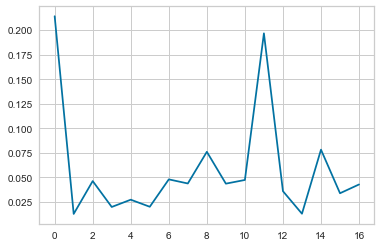

In [226]:
# let's look at the important features
plt.plot(np.arange(0,len(X.columns)), rf.feature_importances_)

It appears the most importance features in predicting the average_rating is the year published and number of people wanting the game.

## Question 4

In [231]:
# The ugliest possible way to implement random sampling for 10 Kfold
# I know I should have used KFold but I needed to convert my dataframe into a numpy array for indexes
# to work correctly so this was the lesser of two evils.
scores = []

for x in np.arange(1,10):
    # Split our data into train and test
    xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=.2)
    
    rf.fit(xTrain, yTrain)
    yHat = rf.predict(xTest)
    rmse = np.sqrt(mean_squared_error(yHat, yTest))
    scores.append(rmse)

In [233]:
print(f"10 KFold Cross Validation: {np.mean(scores)}")

10 KFold Cross Validation: 1.0797866057895926


Based on the number above, I would expect the model to perform with a RMSE of 1.08

## Question 5

Unsure, I would have to spend more time with the data.